In [15]:
# パッケージのimport
import random
import math
import time
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
class Self_Attention(nn.Module):
    """ Self-AttentionのLayer"""
    def __init__(self, in_dim):
            super(Self_Attention, self).__init__()
            
            # 1×1の畳み込み層によるpointwise convolutionを用意
            # query : 入力xの転置
            self.query_conv = nn.Conv2d(
                in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
            # key : 入力x
            self.key_conv = nn.Conv2d(
                in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
            # value : Attention Map beta と掛け算する対象
            self.value_conv = nn.Conv2d(
                in_channels=in_dim, out_channels=in_dim, kernel_size=1)
            
            # Attention Map作成時の規格化のソフトマックス
            self.softmax = nn.Softmax(dim=-2)
            
            # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
            # output = x +gamma*o
            # 最初はgamma=0で、学習させていく
            self.gamma = nn.Parameter(torch.zeros(1))
            
    def forward(self, x):
        
        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # サイズ：B,C',N
        
        proj_query = proj_query.permute(0, 2, 1) # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3]) # サイズ：B,C',N
        
        # かけ算
        # https://pytorch.org/docs/stable/torch.html#torch.bmm
        S = torch.bmm(proj_query, proj_key)  #バッチごとの行列かけ算
        
        attention_map_T = self.softmax(S) # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる
        
        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1)) # Attention Mapは転置してかけ算
        
        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma*o
        
        return out, attention_map

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(z_dim, image_size*8, 
                                                   kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*8, image_size*4, 
                                                    kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*4, image_size*2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))

        # Self-Attentin層を追加
        self.self_attention1 = Self_Attention(in_dim=image_size*2)
        
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.ConvTranspose2d(image_size*2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        # Self-Attentin層を追加
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        # 注意：白黒画像なので出力チャネルは1つだけ
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 3, kernel_size=4, 
                                                  stride=2, padding=1),
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

In [13]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=100, image_size=64):
        super(Discriminator, self).__init__()
        
        # 注意：白黒画像なので入力チャネルは1つだけ
        self.layer1 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.self_attention1 = Self_Attention(in_dim=image_size*4)
        
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(
                nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.self_attention2 = Self_Attention(in_dim=image_size*8)
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

In [5]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform():
    """画像の前処理クラス"""
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
            
    def __call__(self, img):
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset):
    
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''
        
        img_path = self.file_list[index]
        img = Image.open(img_path) # [高さ][幅]白黒
        
        img_transformed = self.transform(img)
        
        return img_transformed            
    

In [16]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list= glob.glob('anime/*png')

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 3, 64, 64])


In [18]:
def train_model(G, D, dataloader, num_epochs):
   # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # パラメータをハードコーディング
    z_dim = 100
    mini_batch_size = 64
    
    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに
    
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    
    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウンタをセット
    iteration = 1
    logs = []

        # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')
        
        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)
            
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)
            
            # 真の画像を判定
            d_out_real, _, _ = D(imges)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差を計算→hinge version of the adversarial lossに変更
            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            
            d_loss = d_loss_real + d_loss_fake
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差を計算→hinge version of the adversarial lossに変更
            g_loss = - d_out_fake.mean()
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # print("総イテレーション回数:", iteration)

    return G, D

In [21]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(z_dim=100, image_size=64)
D = Discriminator(z_dim=100, image_size=64)

# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [22]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 1
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/1
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:3.7453 ||Epoch_G_Loss:6.3127
timer:  81.3572 sec.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

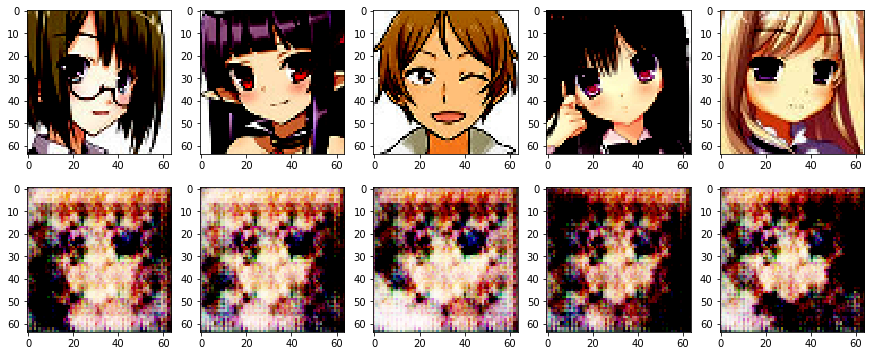

In [39]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 64
z_dim = 100
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
images = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
        # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].cpu().detach().numpy().transpose(1, 2, 0), 'gray')
    
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[0][i].cpu().detach().numpy().transpose(1, 2, 0))

TypeError: Invalid shape (3, 64, 64) for image data

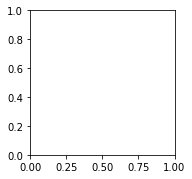

In [46]:
# Attentiom Mapを出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    # 上段に生成した画像データを
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[0][i].cpu().detach().numpy(), 'gray')

    # 下段にAttentin Map1の画像中央のピクセルのデータを
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 中央に着目
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

In [45]:
fake_images[0].size()

torch.Size([64, 3, 64, 64])